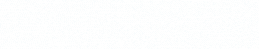

#**MVJ College of Engineering Under Visvesvaraya Technological University**
###**Department of Electronics and Communication Engineering**

###**Flask Application Script**


---


This Application Script is created as a part of 8th Semester Major-Project.

Team Name  - Team OneShot

1MJ18EC122 - Satyam Oza R

1MJ18EC123 - Shankar S

1MJ18EC126 - Shireesha D C

1MJ18EC146 - Vedashree H A

##**Gathering Pre-requisites** 

In [ ]:
!sudo apt update
!sudo apt install ngrok
!pip install flask-ngrok
!pip install flask-bootstrap
!pip install flask==0.12.2
!pip install pyngrok==4.1.1
!ngrok authtoken '21AU4edxV3FLeFDhRVF1j8B3rvY_2KKLp6Vht6uJnCu6gHmoY'
!curl -s https://ngrok-agent.s3.amazonaws.com/ngrok.asc | sudo tee /etc/apt/trusted.gpg.d/ngrok.asc >/dev/null && echo "deb https://ngrok-agent.s3.amazonaws.com buster main" | sudo tee /etc/apt/sources.list.d/ngrok.list

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:5 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages [806 kB]
Get:10 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 http://security.ubuntu.com/ubuntu bionic-security/main amd64 

##**Connecting to Google Drive Resources & Database**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/My Drive/Glaucoma_Detection'

Mounted at /content/drive
/content/drive/My Drive/Glaucoma_Detection


##**Web-App Backend**

In [ ]:
# Importing necessary modules
import os
import cv2
import numpy as np
from time import time
import matplotlib.pyplot as plt
from flask_ngrok import run_with_ngrok
from google.colab.patches import cv2_imshow
from tensorflow.keras.models import load_model
from flask import Flask, render_template , request 
from flask import Flask, render_template, request, session, redirect, url_for, flash

# Defining Path of Assets Folder
UPLOAD_FOLDER = 'flask_app/assets/images'
ALLOWED_EXTENSIONS = set(['png', 'jpg', 'jpeg', 'gif'])

# Creating Application Object Using Flask
app = Flask(__name__, static_url_path='/assets', static_folder='flask_app/assets', template_folder='flask_app')

# Configuring the Assets Path
app.config['UPLOAD_FOLDER'] = UPLOAD_FOLDER

# Server Instance with 'ngrok'
run_with_ngrok(app)

# Function to Set Cache-Configuration to 'no-cache' in our case
@app.after_request
def add_header(r):
    r.headers["Cache-Control"] = "no-cache, no-store, must-revalidate"
    r.headers["Pragma"] = "no-cache"
    r.headers["Expires"] = "0"
    r.headers['Cache-Control'] = 'public, max-age=0'
    return r

# Routing default to 'index.html'
@app.route('/')
def root():
    return render_template('index.html')

@app.route('/index.html')
def index():
    return render_template('index.html')

@app.route('/camera.html')
def camera():
    return render_template('camera.html')

@app.route('/capture.html')
def capture():
    return render_template('capture.html')

@app.route('/detect.html')
def detect():
    return render_template('detect.html')

@app.route('/upload.html')
def upload():
    return render_template('upload.html')


# When User Chooses to upload sample image this method will be called
@app.route('/upload', methods=['POST', 'GET'])
def upload_pic():
    t_init = time()
    if request.method == 'POST':
        if 'file' not in request.files:
            flash('No file part')
            return redirect(request.url)
        file = request.files['file']
        if file.filename == '':
            flash('No selected file')
            return redirect(request.url)
        if file:
            file.save(os.path.join(
                app.config['UPLOAD_FOLDER'],'image.jpg'))
    
    # Converting Image to Processable format
    img = cv2.imread('flask_app/assets/images/image.jpg')

    # Performing the Image Processing Using OpenCV
    image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    image = np.array(image) / 255
    image = np.expand_dims(image, axis=0)

    transformed_glaucoma = cv2.applyColorMap(img, cv2.COLORMAP_HSV)
    transformed_glaucoma = cv2.resize(transformed_glaucoma, (224, 224))

    gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
    ret,thresh = cv2.threshold(gray_image,100,300,0) 
    contours,hierarchy = cv2.findContours(thresh,cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) 
    contoured_glaucoma = cv2.drawContours(img,contours,-1,(0,300,0),1)
    contoured_glaucoma = cv2.resize(contoured_glaucoma, (224, 224))

    os.remove('flask_app/assets/images/transformed_image.jpg')
    os.remove('flask_app/assets/images/contoured_image.jpg')

    cv2.imwrite('flask_app/assets/images/transformed_image.jpg', transformed_glaucoma)
    cv2.imwrite('flask_app/assets/images/contoured_image.jpg', contoured_glaucoma)

    # Loading Models to the Runtime
    inception_resnet_v2_glaucoma = load_model('inception_resnet_v2_glaucoma.h5')

    # Predicting the Probability of the result case
    inception_resnet_v2_glaucoma_pred = inception_resnet_v2_glaucoma.predict(image)
    probability = inception_resnet_v2_glaucoma_pred[0]
    print("inception_resnet_v2_glaucoma Predictions:")
    if probability[0] < 0.5:
        inception_resnet_v2_glaucoma_pred = str('%.2f' % (probability[1] * 100) + '% Glaucoma POSITIVE')
    else:
        inception_resnet_v2_glaucoma_pred = str('%.2f' % ((probability[0]) * 100) + '% Glaucoma NEGATIVE')
    print(inception_resnet_v2_glaucoma_pred)

    # timer functionality
    t_final = time()

    elapsed_time = t_final - t_init
    elapsed_min = int(elapsed_time // 60)
    elapsed_sec = int(elapsed_time % 60)

    return render_template('detect.html', glaucoma_pred=inception_resnet_v2_glaucoma_pred, elapsed_min=elapsed_min, elapsed_sec=elapsed_sec)

#server
if __name__ == '__main__':
    app.run()

 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://7564-35-237-89-243.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [14/Jun/2022 06:10:19] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [14/Jun/2022 06:10:19] "GET /assets/css/glaucoma.css HTTP/1.1" 200 -
127.0.0.1 - - [14/Jun/2022 06:10:19] "GET /assets/js/carousal1.js HTTP/1.1" 404 -
127.0.0.1 - - [14/Jun/2022 06:10:19] "GET /assets/images/oneshot.gif HTTP/1.1" 200 -
127.0.0.1 - - [14/Jun/2022 06:10:22] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [14/Jun/2022 06:10:23] "GET /upload.html HTTP/1.1" 200 -
127.0.0.1 - - [14/Jun/2022 06:10:23] "GET /assets/css/glaucoma.css HTTP/1.1" 304 -
127.0.0.1 - - [14/Jun/2022 06:10:51] "POST /upload HTTP/1.1" 200 -


inception_resnet_v2_glaucoma Predictions:
99.97% Glaucoma NEGATIVE
[9.9967897e-01 3.2102127e-04]
0.99967897
0.00032102127


127.0.0.1 - - [14/Jun/2022 06:10:51] "GET /assets/images/contoured_image.jpg HTTP/1.1" 200 -
127.0.0.1 - - [14/Jun/2022 06:10:51] "GET /assets/images/transformed_image.jpg HTTP/1.1" 200 -
127.0.0.1 - - [14/Jun/2022 06:11:38] "POST /upload HTTP/1.1" 200 -


inception_resnet_v2_glaucoma Predictions:
100.00% Glaucoma POSITIVE
[1.1002924e-10 1.0000000e+00]
1.1002924e-10
1.0


127.0.0.1 - - [14/Jun/2022 06:11:39] "GET /assets/images/transformed_image.jpg HTTP/1.1" 200 -
127.0.0.1 - - [14/Jun/2022 06:11:39] "GET /assets/images/contoured_image.jpg HTTP/1.1" 200 -
127.0.0.1 - - [14/Jun/2022 06:12:08] "POST /upload HTTP/1.1" 200 -


inception_resnet_v2_glaucoma Predictions:
100.00% Glaucoma NEGATIVE
[1.00000000e+00 1.18007885e-14]
1.0
1.18007885e-14


127.0.0.1 - - [14/Jun/2022 06:12:08] "GET /assets/images/transformed_image.jpg HTTP/1.1" 200 -
127.0.0.1 - - [14/Jun/2022 06:12:08] "GET /assets/images/contoured_image.jpg HTTP/1.1" 200 -
